***
# **HMC Labs - Maps Analyzer** 

<img style="float: left; padding-right: 80px; padding-left: 5px;" src="img/logo_hmc.png" width="250px" align=”left” >

In the laboratory of **HMC maps** we will perform the following points:
   * Configure the libraries and the dependecies of the laboratory;
   * Read the configuration file of the laboratory;
   * Read the static datasets of terrain, river networks and outlet sections;
   * Read the dynamic datasets of the maps (forcing and outcome datasets);
   * Plot the maps of forcing variables;
   * Plot the maps of outcome variables.    


## **Import libraries and dependencies**

In [22]:
# Notebook configuration
%matplotlib inline
%matplotlib widget

# Noteboook extentions
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#from IPython.display import Image
#from IPython.core.display import HTML 

# Libraries
import os
import sys
import pandas as pd
from argparse import ArgumentParser

from library.common.lib_info_args import logger_name, logger_format
from library.common.lib_utils_logging import set_logging_file

from library.common.lib_data_io_json import read_file_settings

from library.common.lib_data_io_generic import define_file_path_analyzer, \
    define_file_time, define_file_map, define_file_variables, \
    create_darray_map, \
    get_path_root, get_path_home, set_info_mode, \
    convert_tstamp_2_tstr, define_folder_time

from library.common.lib_data_geo_ascii import read_data_grid
from library.common.lib_data_geo_shapefile import read_data_section

from library.common.lib_data_io_netcdf import read_file_map

from library.common.lib_graph_map import plot_map_var

from library.common.lib_utils_time import create_time_range

# Define configuration file
file_name_settings="fp_labs_analyzer_hmc_maps.json"

# Info
print(' ==> Libraries loaded')

 ==> Libraries loaded



### **Configure the flood-proofs laboratory**
- Load the configuration file:

In [3]:
# Read data from settings algorithm file
obj_settings = read_file_settings(file_name_settings)

# Info
print(' ==> Settings information loaded')

 ==> Settings information loaded


- Define objects:

In [4]:
# Define objects
obj_generic = obj_settings['generic']
obj_variables_forcing = obj_settings['variables']['forcing']
obj_variables_results = obj_settings['variables']['results']
obj_template_path = obj_settings['template']['path']
obj_template_geo = obj_settings['template']['geo']
obj_template_var = obj_settings['template']['variable']
obj_template_time = obj_settings['template']['time']
obj_data_static = obj_settings['data']['static']
obj_data_dynamic_source = obj_settings['data']['dynamic']['source']
obj_data_dynamic_destination = obj_settings['data']['dynamic']['destination']

info_mode, info_domain_name = set_info_mode(obj_settings['generic'], tag_type='maps')

info_time_analysis = obj_settings['case_study']['time_analysis']
info_time_start = obj_settings['case_study']['time_start']
info_time_end = obj_settings['case_study']['time_end']
info_time_period_left = obj_settings['case_study']['time_period_left']
info_time_period_right = obj_settings['case_study']['time_period_right']
info_description_analysis = obj_settings['case_study']['description']

# Define analysis time range
info_time_db_analysis_period, info_time_str_analysis_period = create_time_range(
    time_analysis=info_time_analysis, time_start=info_time_start, time_end=info_time_end,
    time_analysis_left_period=info_time_period_left, time_analysis_right_period=info_time_period_right)

 INFO --> Time period is defined from "2022-11-22 11:00" to "2022-11-20 14:00"


- Define path(s)

In [5]:
# Define static and dynamic path root
file_path_home = get_path_home(obj_generic['path_home'])
file_path_root_static = get_path_root(obj_generic['path_root_data_static'], home_path_string=file_path_home)
file_path_root_dynamic_source = get_path_root(
    obj_generic['path_root_data_dynamic_source'], home_path_string=file_path_home)
file_path_root_dynamic_destination = get_path_root(
    obj_generic['path_root_data_dynamic_destination'], home_path_string=file_path_home)

### **Organize and read the static datasets**
- Organize the static datasets:

In [6]:
# Define file static path(s)
obj_filled_path = dict.fromkeys(list(obj_template_path.keys()), file_path_root_static)
file_path_dset_static = define_file_path_analyzer(
    obj_data_static, path_template_raw=obj_template_path, path_template_values=obj_filled_path,
    tag_file_time=None)[0]

- Read the static datasets:

In [7]:
# Read terrain datasets
darray_terrain = read_data_grid(file_path_dset_static['terrain'], var_limit_min=0, var_limit_max=None)
# Read river network datasets
darray_river_network = read_data_grid(file_path_dset_static['river_network'], var_limit_min=0, var_limit_max=1)
# Read sections shapefile
dframe_section = read_data_section(file_path_dset_static['sections'])

In [8]:
# Create geographical object
obj_filled_geo = {'domain_name': info_domain_name}

# Define variables
run_variables_forcing = define_file_variables(obj_variables_forcing, obj_filled_geo)
run_variables_results = define_file_variables(obj_variables_results, obj_filled_geo)

### **Organize and read the dynamic datasets**
- Organize the dynamic datasets:

In [9]:
# Fill dynamic file path(s)
obj_filled_path = dict.fromkeys(list(obj_template_path.keys()), file_path_root_dynamic_source)

In [14]:
# Get time db and reference
info_time_db_dynamic_source_generic, info_time_ref_dynamic_source_generic = define_file_time(
    obj_data_dynamic_source,
    time_format_path='%Y%m%d',
    geo_template_raw=obj_template_path, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values=None,
    path_template_raw=obj_template_path, path_template_values=obj_filled_path)

time_folder_list_forcing = convert_tstamp_2_tstr(info_time_db_dynamic_source_generic['maps_forcing'])
time_folder_list_results = convert_tstamp_2_tstr(info_time_db_dynamic_source_generic['maps_results'])

- Select folder and file of forcing datasets

In [32]:
# Display available run(s)
time_select_obj = widgets.Dropdown(options=time_folder_list_forcing, description='TimeRun', disabled=False, rows=10)
display(time_select_obj)  

Dropdown(description='TimeRun', options=('2022-11-21 00:00:00', '2022-11-17 00:00:00'), value='2022-11-21 00:0…

In [33]:
# Parser the selection from the scroll menu
time_folder_select_forcing = time_select_obj.value
print('select folder of forcing datasets: ' + str(time_folder_select_forcing))

select folder of forcing datasets: 2022-11-21 00:00:00


In [34]:
# Define list of available forcing file(s)
folder_name_forcing_generic = obj_data_dynamic_source['maps_forcing']['folder_name']
obj_filled_time = {'maps_sub_path_forcing': pd.Timestamp(time_folder_select_forcing)}
time_file_list_forcing = define_folder_time(folder_name_forcing_generic,
                                            obj_filled_time, obj_filled_path,
                                            obj_template_time, obj_template_path)

In [35]:
# Display available file(s)
time_select_obj = widgets.Dropdown(options=time_file_list_forcing, description='TimeFile', disabled=False, rows=10)
display(time_select_obj)  

Dropdown(description='TimeFile', options=('2022-11-21 13:00:00', '2022-11-21 13:00:00', '2022-11-21 12:00:00',…

In [36]:
# Parser the selection from the scroll menu
time_file_select_forcing = time_select_obj.value
print('select file of forcing dataset: ' + str(time_file_select_forcing))

select file of forcing dataset: 2022-11-21 13:00:00


- Select folder and file of results datasets

In [40]:
# Display available run(s)
time_select_obj = widgets.Dropdown(options=time_folder_list_results, description='TimeRun', disabled=False, rows=10)
display(time_select_obj)  

Dropdown(description='TimeRun', options=('2022-11-21 00:00:00', '2022-11-17 00:00:00'), value='2022-11-21 00:0…

In [41]:
# Parser the selection from the scroll menu
time_folder_select_results = time_select_obj.value
print('select folder of results dataset: ' + str(time_folder_select_results))

select folder of results dataset: 2022-11-21 00:00:00


In [43]:
# Define list of available results file(s)
folder_name_results_generic = obj_data_dynamic_source['maps_results']['folder_name']
obj_filled_time = {'maps_sub_path_results': pd.Timestamp(time_folder_select_results)}
time_file_list_results = define_folder_time(folder_name_results_generic,
                                            obj_filled_time, obj_filled_path,
                                            obj_template_time, obj_template_path)

In [44]:
# Display available file(s)
time_select_obj = widgets.Dropdown(options=time_file_list_results, description='TimeFile', disabled=False, rows=10)
display(time_select_obj)  

Dropdown(description='TimeFile', options=('2022-11-21 13:00:00', '2022-11-21 13:00:00', '2022-11-21 12:00:00',…

In [45]:
# Parser the selection from the scroll menu
time_file_select_results = time_select_obj.value
print('select file of results dataset: ' + str(time_file_select_results))

select file of results dataset: 2022-11-21 08:00:00


In [46]:
# Define dynamic source folder(s)
obj_data_dynamic_source_forcing = {'maps_forcing': obj_data_dynamic_source['maps_forcing']}
file_path_dynamic_source_forcing = define_file_path_analyzer(
    obj_data_dynamic_source_forcing, tag_file_time='time_reference',
    geo_template_raw=obj_template_path, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_reference': time_file_select_forcing},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path)[0]

obj_data_dynamic_source_results = {'maps_results': obj_data_dynamic_source['maps_results']}
file_path_dynamic_source_results = define_file_path_analyzer(
    obj_data_dynamic_source_results, tag_file_time='time_reference',
    geo_template_raw=obj_template_path, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_reference': time_file_select_results},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path)[0]

In [47]:
# Define dynamic destination folder(s)
obj_filled_path = dict.fromkeys(list(obj_template_path.keys()), file_path_root_dynamic_destination)

obj_data_dynamic_destination_forcing = {'maps_forcing': obj_data_dynamic_destination['maps_forcing']}
file_path_dset_dynamic_destination_forcing, file_act_dset_dynamic_destination_forcing = define_file_path_analyzer(
    obj_data_dynamic_destination_forcing, tag_file_time='time_reference',
    geo_template_raw=obj_template_geo, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_reference': time_file_select_forcing},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path)

obj_data_dynamic_destination_results = {'maps_results': obj_data_dynamic_destination['maps_results']}
file_path_dset_dynamic_destination_results, file_act_dset_dynamic_destination_results = define_file_path_analyzer(
    obj_data_dynamic_destination_results, tag_file_time='time_reference',
    geo_template_raw=obj_template_geo, geo_template_values=obj_filled_geo,
    time_template_raw=obj_template_time, time_template_values={'time_reference': time_file_select_results},
    path_template_raw=obj_template_path, path_template_values=obj_filled_path)

- Read the dynamic datasets:

In [48]:
# Read forcing datasets map
obj_maps_dynamic_forcing = read_file_map(
    file_path_dynamic_source_forcing['maps_forcing'], file_vars_expected=run_variables_forcing)

In [49]:
# Read results datasets map
obj_maps_dynamic_results = read_file_map(
    file_path_dynamic_source_results['maps_results'], file_vars_expected=run_variables_results)

- Extract the dynamic variable(s):

In [50]:
# Extract variables from forcing datasets
darray_map_rain, attrs_map_rain = create_darray_map(
    obj_maps_dynamic_forcing, var_name_in='Rain', var_name_out='rain')
darray_map_airt, attrs_map_airt = create_darray_map(
    obj_maps_dynamic_forcing, var_name_in='Air_Temperature', var_name_out='air_temperature')
darray_map_rh, attrs_map_rh = create_darray_map(
    obj_maps_dynamic_forcing, var_name_in='Relative_Humidity', var_name_out='relative_humidity')

# Extract variables from results datasets
darray_map_sm, attrs_map_sm = create_darray_map(
    obj_maps_dynamic_results,  var_name_in='SM', var_name_out='soil_moisture')
darray_map_lst, attrs_map_lst = create_darray_map(
    obj_maps_dynamic_results, var_name_in='LST', var_name_out='land_surface_temperature')

### **Plot the dynamic datasets in maps format**
- Create the plot of the **soil moisture map**:

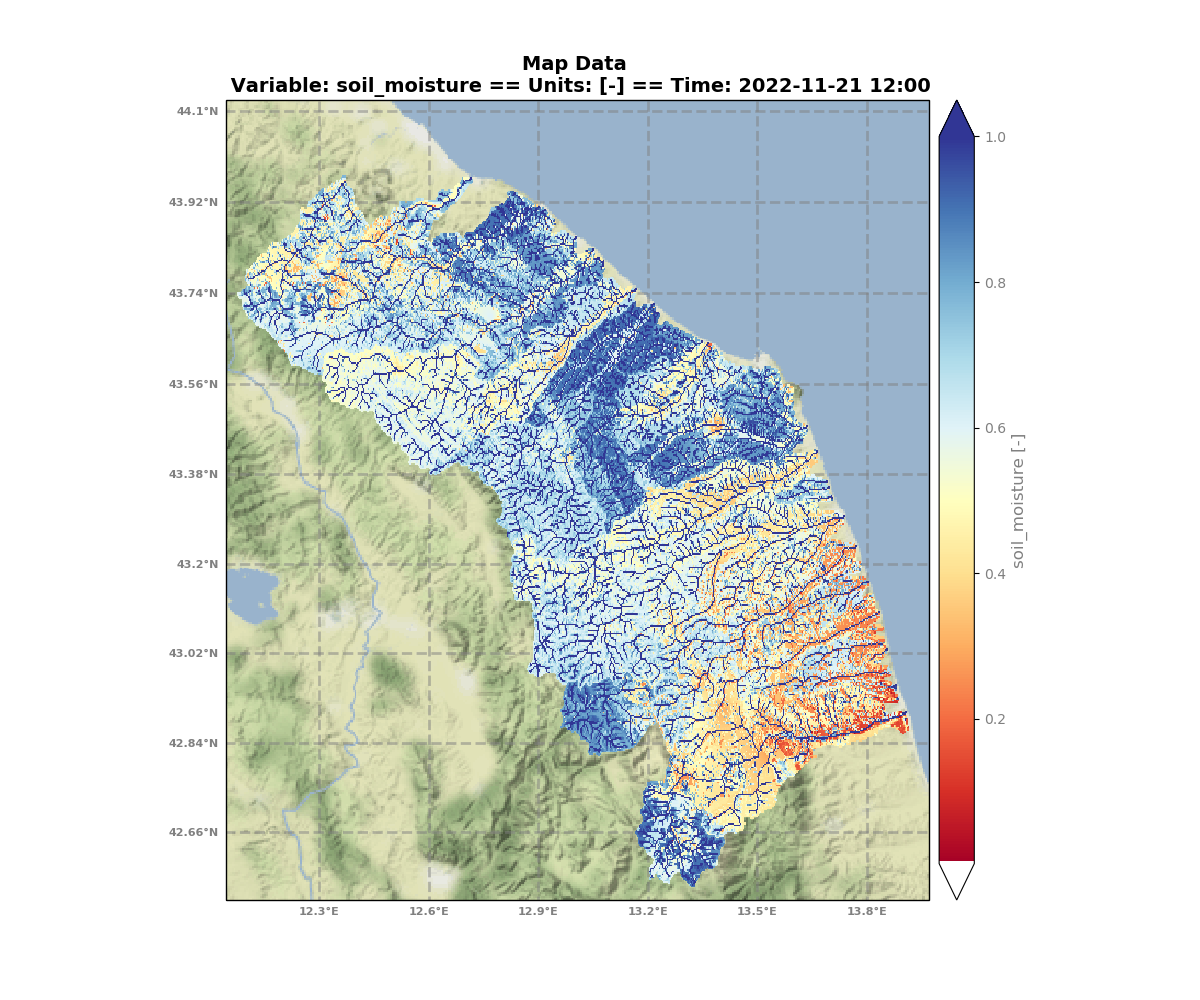

In [51]:
# Plot map soil moisture
file_name_map_sm = define_file_map(
    file_path_dset_dynamic_destination_results['maps_results'], var_name='soil_moisture')
plot_map_var(file_name_map_sm, darray_map_sm, info_time_analysis,
             var_name_data='soil_moisture', var_units='[-]',
             var_name_geo_x='Longitude', var_name_geo_y='Latitude',
             var_limit_min=0, var_limit_max=1)

- Create the plot of the **air temperature map**:

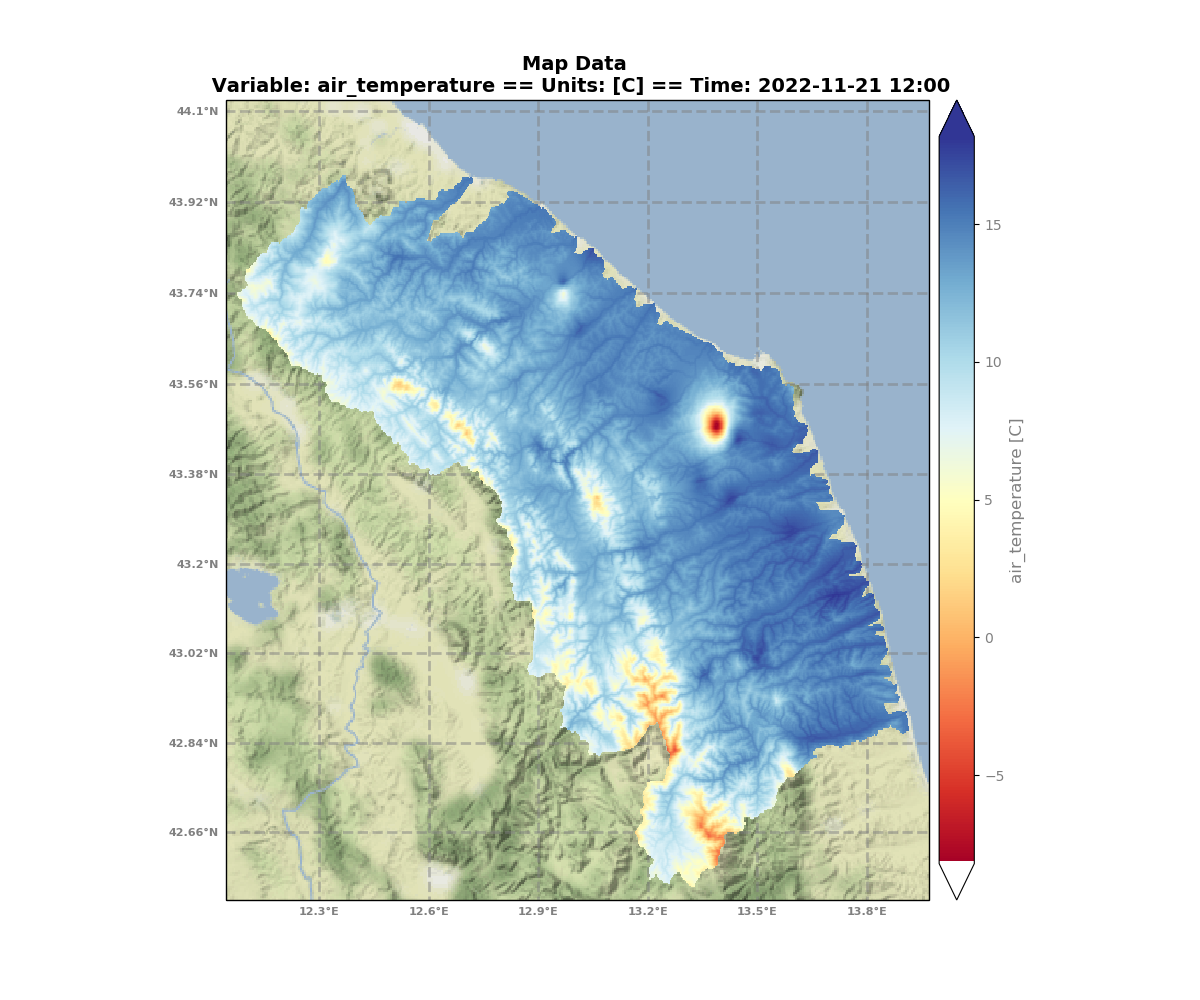

In [52]:
# Plot map air temperature
file_name_map_airt = define_file_map(
    file_path_dset_dynamic_destination_forcing['maps_forcing'], var_name='air_temperature')

plot_map_var(file_name_map_airt, darray_map_airt, info_time_analysis,
             var_name_data='air_temperature', var_units='[C]',
             var_name_geo_x='longitude', var_name_geo_y='latitude')

**Training on-the-job**
- Download/Organize the static and dynamic datasets for a different "time run";
- Select a different case-study (time run);
- Select a different analysis step (time analysis);
- Add/change the variables in the maps plot (have to check the names of the variables in the netcdf forcing or outcome files);
- Add/change the plot of gridded variables (for example using a different map background);
- ...